In [412]:
import warnings
warnings.simplefilter('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('dark_background')
get_ipython().magic('matplotlib inline')

import numpy as np
import scipy as sp
import scipy.signal as sg
import pandas as pd
import sklearn as sk
import tensorflow as tf
import wfdb
from wfdb import processing

from IPython.display import Image

In [413]:
f = open("mit-bih-arrhythmia-database-1.0.0/RECORDS", 'r')
sample_num = []
while True:
    line = f.readline()
    if not line: break
    sample_num.append(line[:-1])
f.close()
print(sample_num)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']


In [ ]:
signals100, fields100 = wfdb.rdsamp('mit-bih-arrhythmia-database-1.0.0/'+'100')
print(signals100)
print(fields100)
wfdb.plot_items(signal = signals100, title = 'sample100')

In [484]:
# 각각의 레코드에 저장된 데이터들을 취합
signals = []
fields = []
records = []
for i in range(len(sample_num)):
    globals()['signals{}'.format(sample_num[i])] , globals()['fields{}'.format(sample_num[i])] = wfdb.rdsamp('mit-bih-arrhythmia-database-1.0.0/'+str(sample_num[i]))
    globals()['records{}'.format(sample_num[i])] = wfdb.rdrecord('mit-bih-arrhythmia-database-1.0.0/'+str(sample_num[i]))
    signals.append(globals()['signals{}'.format(sample_num[i])])
    fields.append(globals()['fields{}'.format(sample_num[i])])
    records.append(globals()['records{}'.format(sample_num[i])])

In [485]:
# 리드II로 측정한 신호가 없는 레코드는 제외
for sample in sample_num:
    if 'MLII' in globals()['fields{}'.format(sample)]['sig_name']:
        pass
    else: sample_num.remove(str(sample))
print(sample_num)

['100', '101', '103', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']


In [486]:
dfs = []
for signal in signals:
    dfs.append(pd.DataFrame(signal))

In [ ]:
dfs

In [ ]:
# index는 환자 번호, column이 timestamp, data는 MLII 전압인 dataframe 생성
dfs = []
for signal in signals:
    dfs.append(pd.DataFrame(signal))
    
dfs_signals = pd.DataFrame(columns = range(650000))
for i in range(len(sample_num)):
    ind = globals()['fields{}'.format(sample_num[i])]['sig_name'].index('MLII')
    dfs_signals.loc[sample_num[i]] = dfs[i][ind]
dfs_signals

In [489]:
# 맨 끝부분 라벨은 제거
dfs_signals.iloc[:,-1].value_counts()

 0.00    32
-1.28    11
 1.28     3
Name: 649999, dtype: int64

In [ ]:
df_signals = dfs_signals.iloc[:, :-1]
df_signals

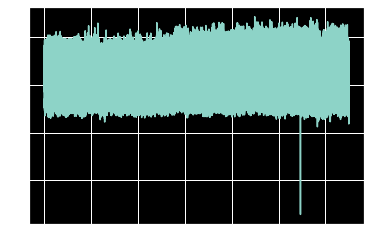

In [492]:
sig100 = df_signals.loc['100',:]
plt.plot(sig100)

In [506]:
sig100[sig100==min(sig100)]

546792   -2.715
Name: 100, dtype: float64

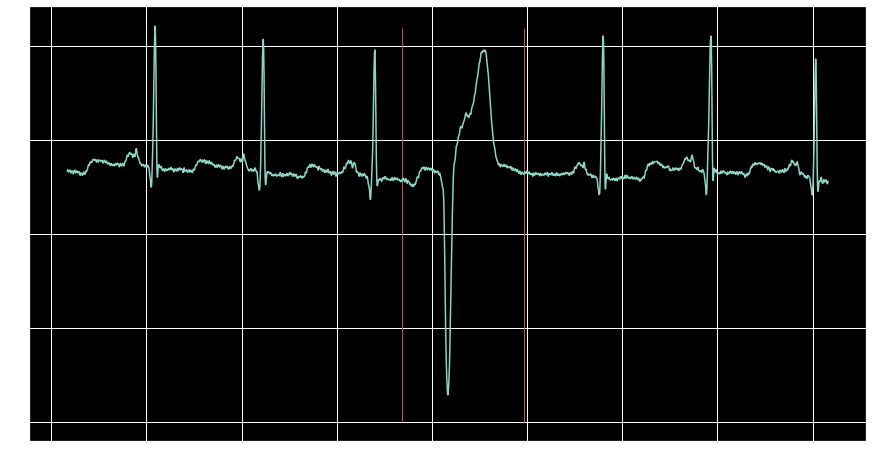

In [512]:
plt.figure(figsize=(15,8))
plt.plot(sig100[546792-1000:546792+1000])
plt.vlines(x=[546792-120,546792+200], ymin=-3, ymax=1.2, linewidth=1, color='r')

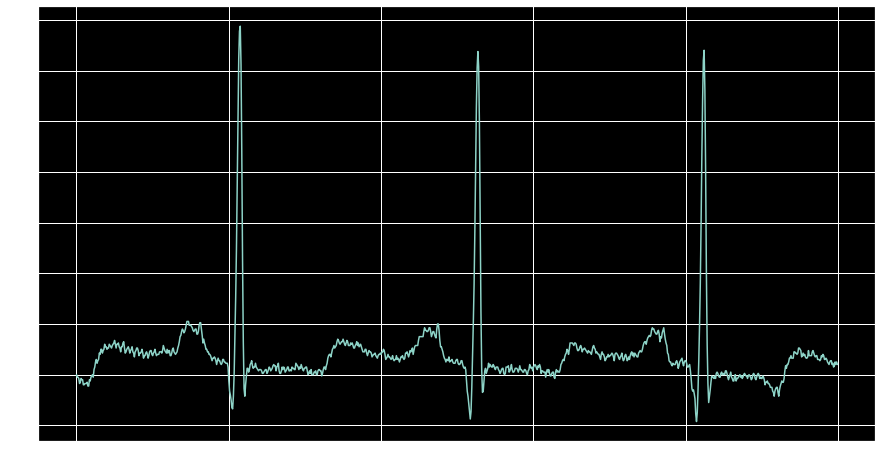

In [516]:
plt.figure(figsize=(15,8))
plt.plot(sig100[6000:7000])

In [517]:
# 버터워스 필터링을 통해 노이즈 제거
a, b = sg.butter(6, (0.01, 100), btype='bandpass', analog=True)
filtered_signal = sg.lfilter(b, a, sig100)
smoothed_signal = sg.cspline1d(filtered_signal, lamb=1000)

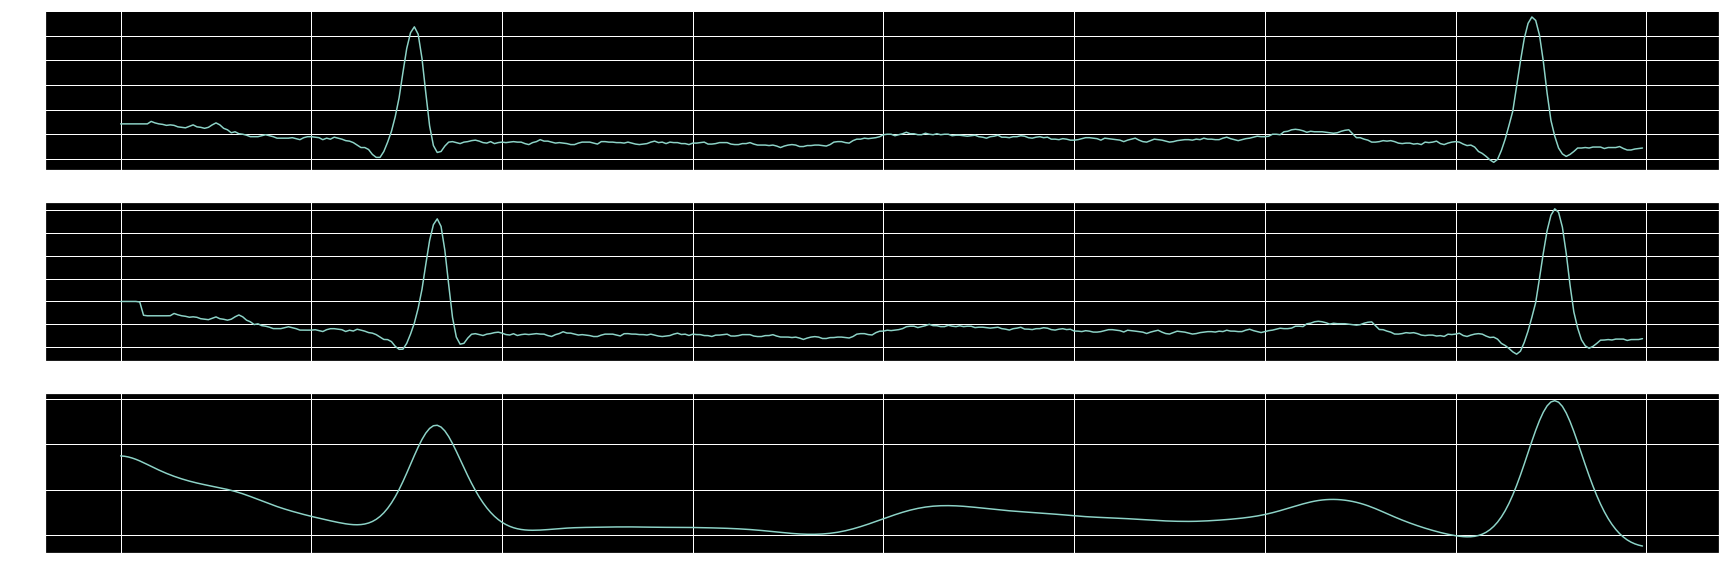

In [518]:
fig, ax = plt.subplots(3, sharex= True, figsize=(30,10))
ax[0].plot(df_signals.iloc[0,:400])
ax[1].plot(filtered_signal[:400])
ax[2].plot(smoothed_signal[:400])

In [519]:
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

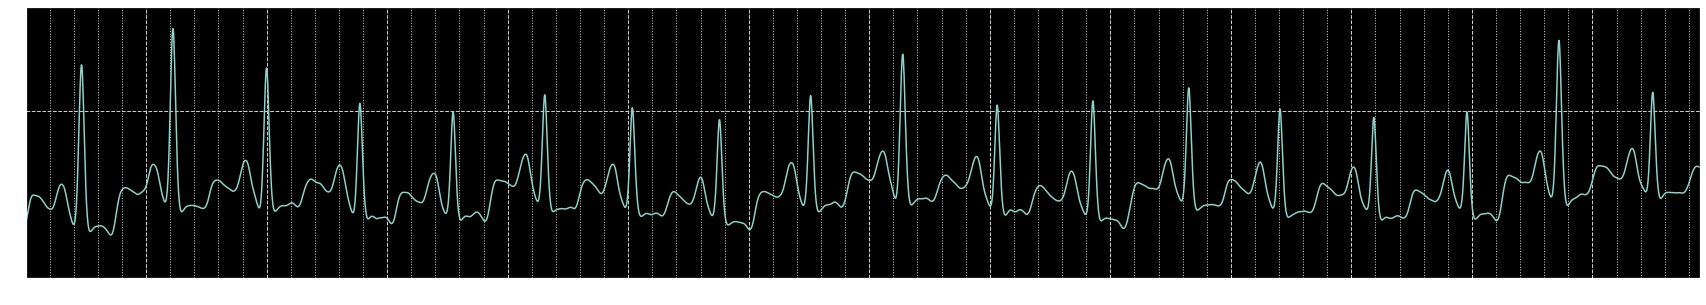

In [520]:
# 가독성을 위해 굵은 점선은 1초, 얇은 점선은 0.2초 눈금
fig, ax = plt.subplots(figsize=(30, 5))

start_point = 200000
end_point = 205000

ax.set_xlim(start_point, end_point)
ax.set_ylim(-0.8,0.5)

ax.xaxis.set_major_locator(MultipleLocator(360))
ax.yaxis.set_major_locator(MultipleLocator(360))

ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))

ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')

ax.plot(range(start_point, end_point),smoothed_signal[start_point:end_point])
ax.plot(list(df_ann_abnormal_100), smoothed_signal[list(df_ann_abnormal_100)], 'rx', marker='x', markersize=12)

ax.set_xticks(np.arange(start_point,end_point,360))

plt.show()

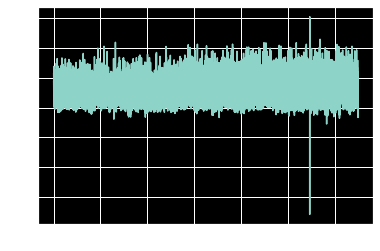

In [521]:
plt.plot(smoothed_signal)

In [524]:
smoothed_signal.mean()

-0.33090472529164544

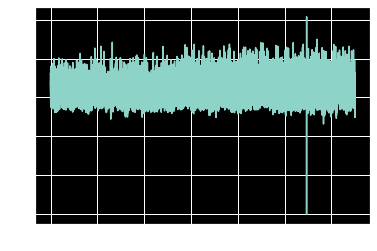

In [526]:
# 신호 정규화
normalized_signal = (smoothed_signal-smoothed_signal.mean()) / smoothed_signal.std()
plt.plot(normalized_signal)

In [543]:
# wfdb 내장 라이브러리로  ECG 피크 검출(PQRST의 R부분)
def peaks_hr(sig, peak_inds, fs, title, figsize=(20, 10), saveto=None):
    "Plot a signal with its peaks and heart rate"

    hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', 
                 color='#8b0000', label='Peak', markersize=12)
    
    ax_right.plot(np.arange(N), hrs, label='Heart rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    #ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    
    ax_right.set_ylabel('Heart rate (bpm)', color='m')

    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.xlim((20000,22000))    # 일부분만 확대
    plt.show()

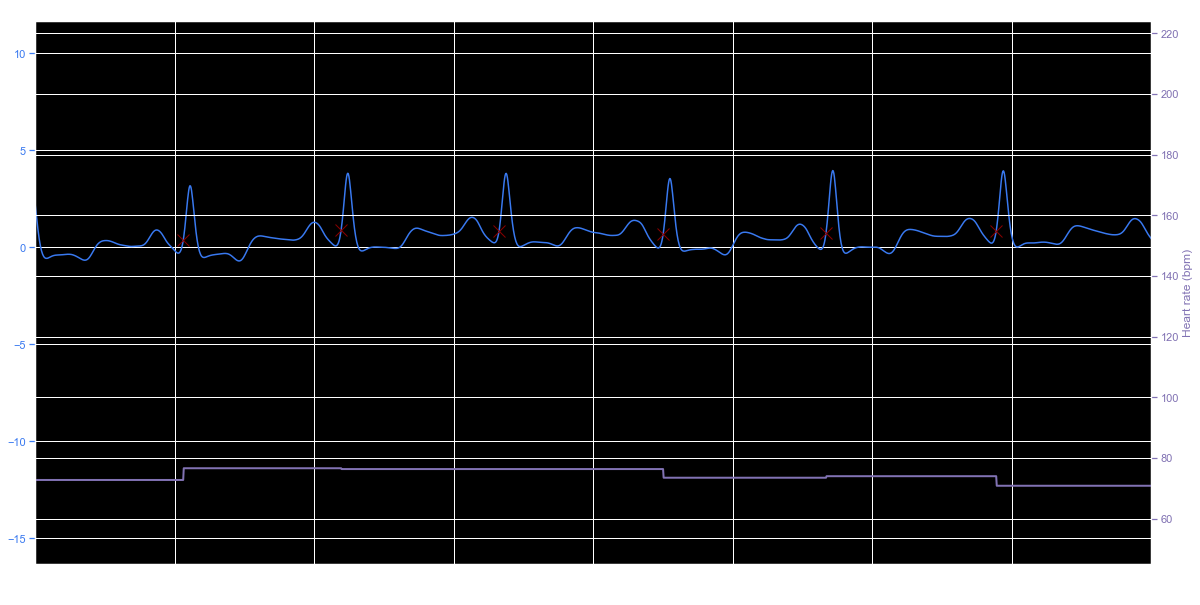

In [544]:
qrs_inds = processing.qrs.gqrs_detect(sig=normalized_signal, fs=records100_a.fs)

peaks_hr(sig=normalized_signal.reshape(len(normalized_signal),1), peak_inds=qrs_inds, fs=records100_a.fs,
         title="GQRS peak detection on record 100")

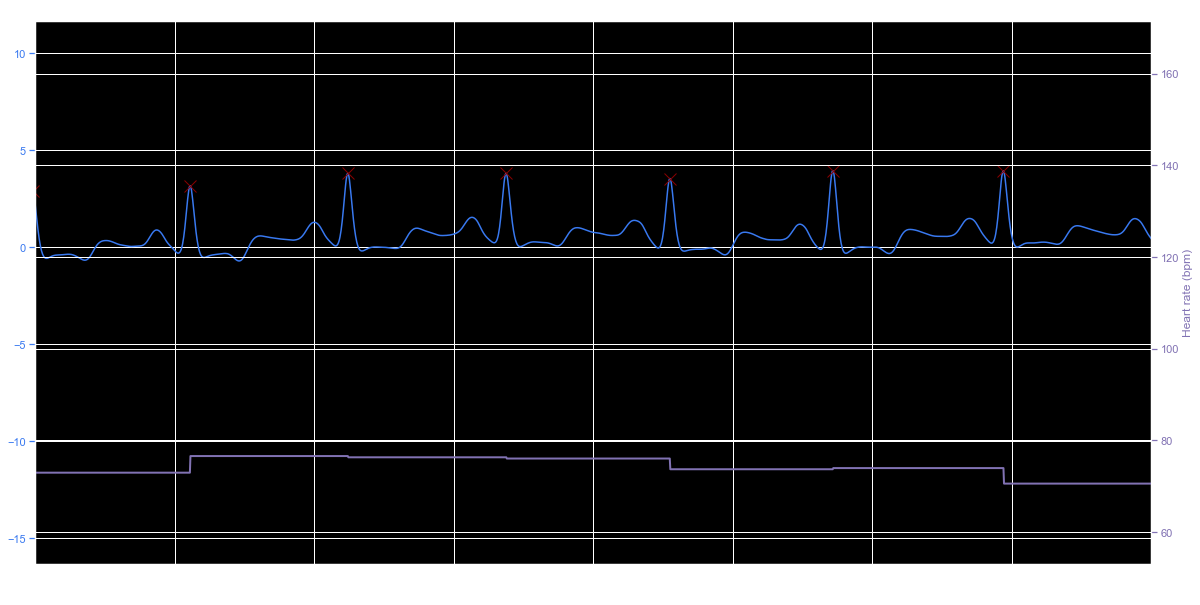

In [545]:
min_bpm = 20
max_bpm = 230

search_radius = int(records100_a.fs * 60 / max_bpm)
corrected_peak_inds = processing.peaks.correct_peaks(normalized_signal, 
                                                     peak_inds=qrs_inds,
                                                     search_radius=search_radius, 
                                                     smooth_window_size=150)

peaks_hr(sig=normalized_signal.reshape(len(normalized_signal),1), peak_inds=sorted(corrected_peak_inds), fs=records100.fs, 
         title="Corrected GQRS peak detection on sampledata/100")

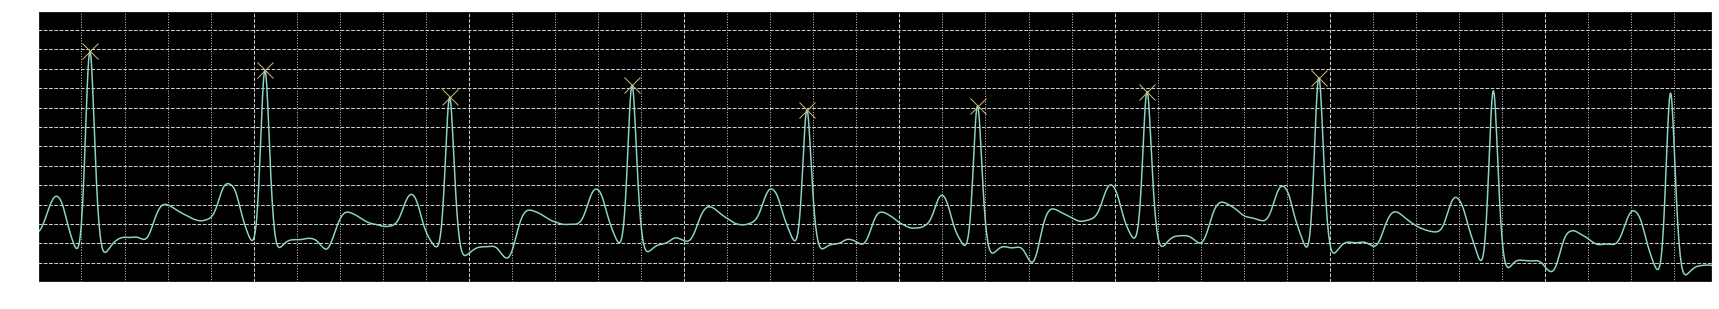

In [546]:
fig, ax = plt.subplots(figsize=(30, 5))

start_point = 29500
end_point = 32300

ax.set_xlim(start_point, end_point)
ax.set_ylim(-1.5,5)

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(1))

ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(1))

ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')

ax.plot(range(start_point, end_point), normalized_signal[start_point:end_point])
ax.plot(corrected_peak_inds[99:110], normalized_signal[corrected_peak_inds[99:110]], 'yx', marker='x', markersize=16)

ax.set_xticks(np.arange(start_point,end_point,360))
ax.set_yticks(np.arange(-1,6,0.5))

plt.show()

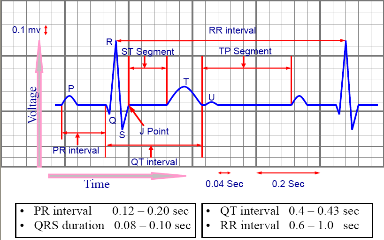

In [547]:
Image('../ecg_1_-384x240.png', width = 500)

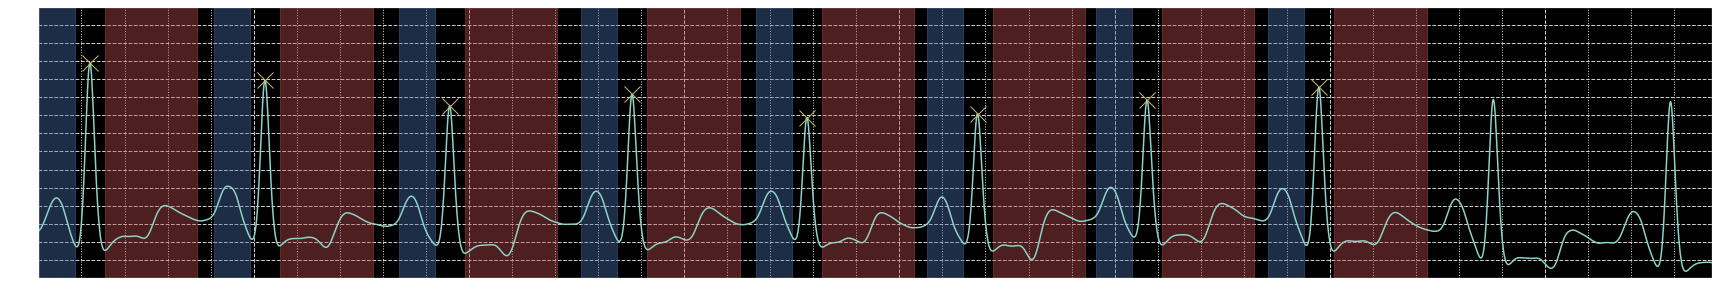

In [552]:
# 피크를 기준으로 앞부분으로 25~85만큼을 PR interval, 뒷부분으로 25~180만큼을 QT interval이라고 가정

pr_min = 25
pr_max = 85
qt_min = 25
qt_max = 180

fig, ax = plt.subplots(figsize=(30, 5))

start_point = 29500
end_point = 32300

ax.set_xlim(start_point, end_point)
ax.set_ylim(-1.5,6)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))

ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(1))

ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')

ax.plot(range(start_point, end_point), normalized_signal[start_point:end_point])
ax.plot(corrected_peak_inds[99:110], normalized_signal[corrected_peak_inds[99:110]], 'yx', marker='x', markersize=16)

ax.set_xticks(np.arange(start_point,end_point,360))
ax.set_yticks(np.arange(-1,6,0.5))

for peak in corrected_peak_inds[99:110]:
    ax.axvspan(peak-pr_max, peak-pr_min, alpha=0.4, color = 'b')
    ax.axvspan(peak+qt_max, peak+qt_min, alpha=0.4, color = 'r')

plt.show()

In [ ]:
# 피크를 기준으로 좌로 85 우로 180만큼을 ECG의 한 beat라고 가정

inds = []
for ind in corrected_peak_inds:
    inds.append(list(range(ind-85,ind+180)))
inds[0]

In [ ]:
# 맨 끝 피크는 +180을 할 경우 기록된 데이터 범위에서 벗어나니 삭제
peak_inds_df = pd.DataFrame(inds).iloc[:-1,:]
peak_inds_df

In [ ]:
# 2264개의 각 beat를 순서대로 index로 갖고, columns를 time, value를 해당 signal의 전압으로 갖는 Dataframe 생성 
ecg_seperated = pd.DataFrame(columns = range(len(peak_inds_df.columns)), index = range(len(peak_inds_df.index)))
ecg_seperated

In [556]:
for i in range(len(inds)-1):
    ecg_seperated.loc[i,:] = normalized_signal[inds[i]]
ecg_seperated

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,...,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264
0,0.0145432,0.0261212,0.0387565,0.0526643,0.0680328,0.0850128,0.10382,0.124796,0.148271,0.174463,0.203375,0.234844,0.268597,0.304263,0.341418,0.379631,0.418389,0.457061,0.494902,0.531172,0.5651,0.595819,0.622565,0.644696,0.661784,0.673636,0.680233,0.68164,0.677882,0.669013,0.655086,0.636158,0.612305,0.583598,0.550089,0.511798,0.468791,0.421335,0.370026,0.315863,0.259984,0.203401,0.147037,0.0916649,0.0378782,-0.0140129,-0.0639308,-0.111938,-0.158108,-0.202517,-0.245158,-0.285977,-0.324953,-0.362096,-0.397374,-0.430673,-0.46184,-0.490618,-0.51668,-0.539415,...,-0.225414,-0.186515,-0.151993,-0.1218,-0.0958517,-0.073971,-0.0558351,-0.0410008,-0.029076,-0.0197389,-0.0127087,-0.00767672,-0.0043079,-0.00217609,-0.000959585,-0.000520021,-0.000716153,-0.00143241,-0.00250336,-0.00371607,-0.00496398,-0.00628554,-0.00774799,-0.00940606,-0.0113729,-0.0137473,-0.0166859,-0.0204018,-0.0251192,-0.0309508,-0.0378556,-0.0457476,-0.0545348,-0.0641885,-0.0746939,-0.0859294,-0.0977658,-0.11006,-0.122648,-0.135443,-0.148312,-0.1611,-0.173578,-0.185512,-0.196731,-0.207154,-0.216742,-0.225487,-0.23336,-0.240269,-0.246205,-0.251278,-0.255671,-0.259555,-0.263043,-0.266191,-0.269106,-0.27195,-0.27493,-0.278104
1,-0.292144,-0.282388,-0.270627,-0.256645,-0.240235,-0.221211,-0.199345,-0.174426,-0.146242,-0.114649,-0.0796714,-0.0415405,-0.00068575,0.0423099,0.086793,0.132154,0.17775,0.222903,0.266933,0.309196,0.349121,0.38617,0.419803,0.449514,0.47485,0.495458,0.511182,0.522119,0.528409,0.530183,0.527588,0.520758,0.509881,0.495136,0.476652,0.454331,0.427862,0.396822,0.360833,0.319787,0.273925,0.223796,0.170024,0.113311,0.0544087,-0.00587298,-0.0667658,-0.12761,-0.187951,-0.247404,-0.305637,-0.362311,-0.417186,-0.470179,-0.521232,-0.570148,-0.616567,-0.659967,-0.699694,-0.735004,...,-0.00514632,0.00100396,0.00470704,0.00630213,0.00609341,0.00434699,0.00125701,-0.0029404,-0.00800109,-0.0137484,-0.0201109,-0.0271523,-0.0349496,-0.0435435,-0.0529335,-0.0631858,-0.0744608,-0.0868525,-0.100405,-0.11499,-0.130411,-0.146507,-0.163179,-0.180297,-0.197682,-0.215091,-0.23224,-0.24899,-0.265326,-0.281263,-0.296791,-0.311819,-0.326194,-0.339738,-0.352382,-0.36408,-0.374801,-0.384552,-0.393406,-0.401462,-0.408903,-0.415918,-0.422648,-0.429102,-0.435266,-0.441067,-0.446474,-0.451499,-0.456077,-0.460091,-0.463336,-0.465674,-0.467108,-0.467701,-0.467502,-0.466572,-0.464956,-0.462719,-0.460067,-0.457269
2,-0.394113,-0.374466,-0.351613,-0.325595,-0.296545,-0.264597,-0.22999,-0.19302,-0.154075,-0.113669,-0.0724333,-0.0309245,0.0103821,0.0510518,0.0906117,0.128552,0.164405,0.197751,0.228263,0.255636,0.279555,0.299711,0.31586,0.327883,0.335844,0.33987,0.340089,0.336554,0.329202,0.317968,0.302762,0.283434,0.259753,0.231463,0.198267,0.159902,0.116246,0.0674471,0.0140752,-0.0429831,-0.10264,-0.163784,-0.225246,-0.286004,-0.345258,-0.40253,-0.457642,-0.510628,-0.561593,-0.610703,-0.658216,-0.704469,-0.749874,-0.794793,-0.839489,-0.884088,-0.928608,-0.972999,-1.01705,-1.06016,...,0.161596,0.163021,0.162834,0.161246,0.158521,0.154895,0.150537,0.145441,0.139541,0.132803,0.125269,0.1171,0.10843,0.0992895,0.0896551,0.0794945,0.068783,0.0575852,0.0459521,0.0338912,0.0214163,0.00859759,-0.00446368,-0.0176657,-0.0309698,-0.044353,-0.0578261,-0.0712693,-0.084455,-0.0971176,-0.109101,-0.120424,-0.131193,-0.141513,-0.151466,-0.161073,-0.170355,-0.179409,-0.188351,-0.197198,-0.205891,-0.214291,-0.222248,-0.229715,-0.236701,-0.243224,-0.249264,-0.254796,-0.259869,-0.264631,-0.269294,-0.274085,-0.279198,-0.284793,-0.290946,-0.29769,-0.30504,-0.31295,-0.321192,-0.329497
3,-0.247522,-0.21986

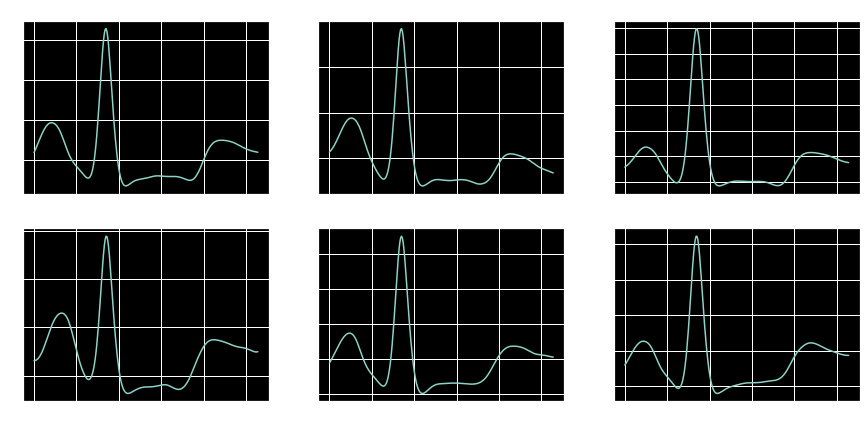

In [557]:
plt.figure(figsize=(15,7))
for i in range(1,7):
    plt.subplot(2, 3, i)
    plt.plot(ecg_seperated.sample(i).iloc[0,:])
    plt.title(f'sample {i}')

plt.show()